In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test_df = pd.read_csv('/content/drive/My Drive/hse-dab-lt-naf-24/lt_test.csv')
train_df = pd.read_csv('/content/drive/My Drive/hse-dab-lt-naf-24/lt_train.csv')

test_df.head(), train_df.head()


(   product_id  location_id   period_dt    id
 0       19474          425  2019-04-08     0
 1       19581          862  2019-04-08  1772
 2       19581          862  2019-04-15  1773
 3       19581          862  2019-04-22  1774
 4       19581          862  2019-04-29  1775,
     period_dt  NUM_CONSULTANT  PRICE_AFTER_DISC  PRICE_REGULAR  \
 0  2019-04-08             0.0            1049.0         1049.0   
 1  2017-05-08             0.0             474.5          949.0   
 2  2017-05-15             0.0             474.5          949.0   
 3  2017-05-22             0.0             474.5          949.0   
 4  2017-05-29             0.0             474.5          949.0   
 
    PRODUCT_LVL_RK6  PROMO1_FLAG  PROMO2_FLAG  STORE_LOCATION_LVL_RK2  \
 0             9988          1.0          0.0                      10   
 1             9988          0.0          0.0                      10   
 2             9988          0.0          0.0                      10   
 3             9988        

In [ ]:
train_df.fillna(0, inplace=True)

In [ ]:
# Split the data into features and target
X = train_df.drop(columns=['demand', 'period_dt', 'id'])
y = train_df['demand']

In [ ]:
# Binarize the target for classifier
y_class = (y > 0).astype(int)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y_class, test_size=0.2, random_state=42)

In [ ]:
# Separate majority and minority classes
train_majority = train_df[train_df['demand'] == 0]
train_minority = train_df[train_df['demand'] > 0]

In [ ]:
# Upsample minority class
train_minority_upsampled = resample(train_minority,
                                    replace=True,     # sample with replacement
                                    n_samples=len(train_majority),    # to match majority class
                                    random_state=42) # reproducible results

In [ ]:
train_upsampled = pd.concat([train_majority, train_minority_upsampled])

In [ ]:
# Split the data into features and target
X_upsampled = train_upsampled.drop(columns=['demand', 'period_dt', 'id'])
y_upsampled = train_upsampled['demand']

In [ ]:
# Binarize the target for classifier
y_class_upsampled = (y_upsampled > 0).astype(int)

In [ ]:
# Split the data into training and validation sets
X_train_upsampled, X_val_upsampled, y_train_upsampled, y_val_upsampled = train_test_split(X_upsampled, y_class_upsampled, test_size=0.2, random_state=42)

In [ ]:
# Train a Gradient Boosting Classifier
classifier_gb = GradientBoostingClassifier(random_state=42)
classifier_gb.fit(X_train_upsampled, y_train_upsampled)

# Evaluate the classifier
y_pred_class_gb = classifier_gb.predict(X_val_upsampled)
accuracy_gb = accuracy_score(y_val_upsampled, y_pred_class_gb)
class_report_gb_corrected = classification_report(y_val_upsampled, y_pred_class_gb)

print("Accuracy:", accuracy_gb)
print("Classification Report:", class_report_gb_corrected)

Accuracy: 0.6906198601973684
Classification Report:               precision    recall  f1-score   support

           0       0.68      0.73      0.70     97216
           1       0.71      0.66      0.68     97344

    accuracy                           0.69    194560
   macro avg       0.69      0.69      0.69    194560
weighted avg       0.69      0.69      0.69    194560



In [ ]:
# Filter the data for non-zero demand
non_zero_df = train_df[train_df['demand'] > 0]

X_reg = non_zero_df.drop(columns=['demand', 'period_dt', 'id'])
y_reg = non_zero_df['demand']

# Split the data into training and validation sets
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Train the regressor
regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train_reg, y_train_reg)

# Evaluate the regressor
y_pred_reg = regressor.predict(X_val_reg)
mse = mean_squared_error(y_val_reg, y_pred_reg)
r2 = r2_score(y_val_reg, y_pred_reg)

print("MSE:", mse)
print("R2 Score:", r2)

MSE: 1.3955230605487066
R2 Score: 0.49717386105094863


In [ ]:
# Ensure the test set has the same features as the training set
required_features = X_train.columns
X_test = test_df.drop(columns=['period_dt', 'id'])
X_test = X_test.reindex(columns=required_features, fill_value=0)

# Predict using the Gradient Boosting Classifier
test_pred_class_gb = classifier_gb.predict(X_test)

# Initialize the final predictions with zeros
test_predictions = [0] * len(test_df)

# Predict using the regressor for non-zero cases
non_zero_indices = [i for i, val in enumerate(test_pred_class_gb) if val == 1]
X_test_non_zero = X_test.iloc[non_zero_indices]
test_pred_reg = regressor.predict(X_test_non_zero)

# Place the regressor predictions in the final predictions
for idx, pred in zip(non_zero_indices, test_pred_reg):
    test_predictions[idx] = pred

# Prepare the final submission dataframe
submission_df = test_df.copy()
submission_df['demand'] = test_predictions

print(submission_df.head())

   product_id  location_id   period_dt    id  demand
0       19474          425  2019-04-08     0     0.0
1       19581          862  2019-04-08  1772     0.0
2       19581          862  2019-04-15  1773     0.0
3       19581          862  2019-04-22  1774     0.0
4       19581          862  2019-04-29  1775     0.0


In [ ]:
submission_df = submission_df.drop(columns=['product_id', 'location_id', 'period_dt'])

In [ ]:
print(submission_df.head())

     id  demand
0     0     0.0
1  1772     0.0
2  1773     0.0
3  1774     0.0
4  1775     0.0


In [ ]:
submission_df.to_csv('/content/drive/My Drive/hse-dab-lt-naf-24/predicted_demand.csv', index=False)

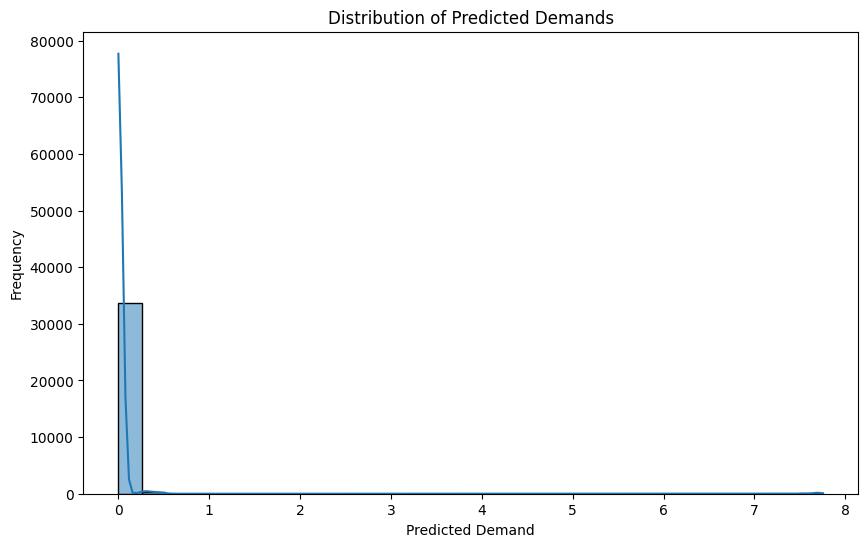

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of predicted demands
plt.figure(figsize=(10, 6))
sns.histplot(submission_df['demand'], bins=30, kde=True)
plt.title('Distribution of Predicted Demands')
plt.xlabel('Predicted Demand')
plt.ylabel('Frequency')
plt.show()

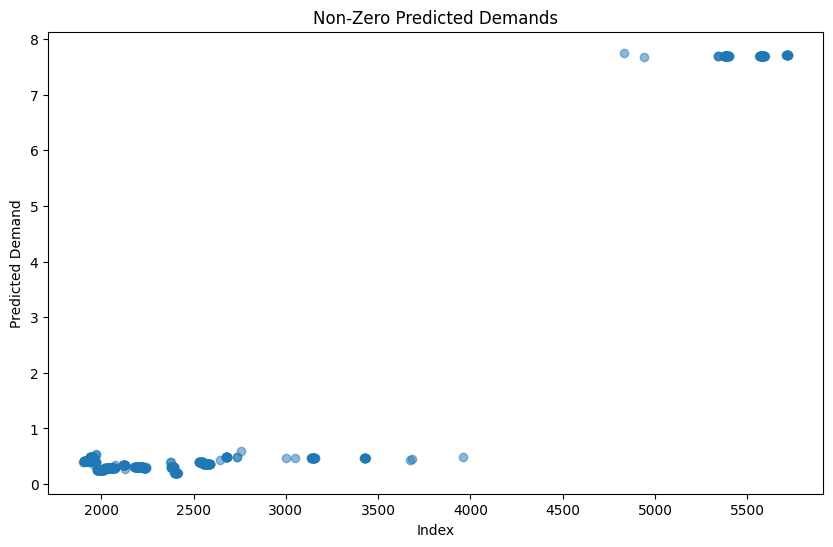

In [ ]:
# Filter non-zero predicted demands
non_zero_predictions = submission_df[submission_df['demand'] > 0]

# Scatter plot of non-zero predicted demands
plt.figure(figsize=(10, 6))
plt.scatter(non_zero_predictions.index, non_zero_predictions['demand'], alpha=0.5)
plt.title('Non-Zero Predicted Demands')
plt.xlabel('Index')
plt.ylabel('Predicted Demand')
plt.show()

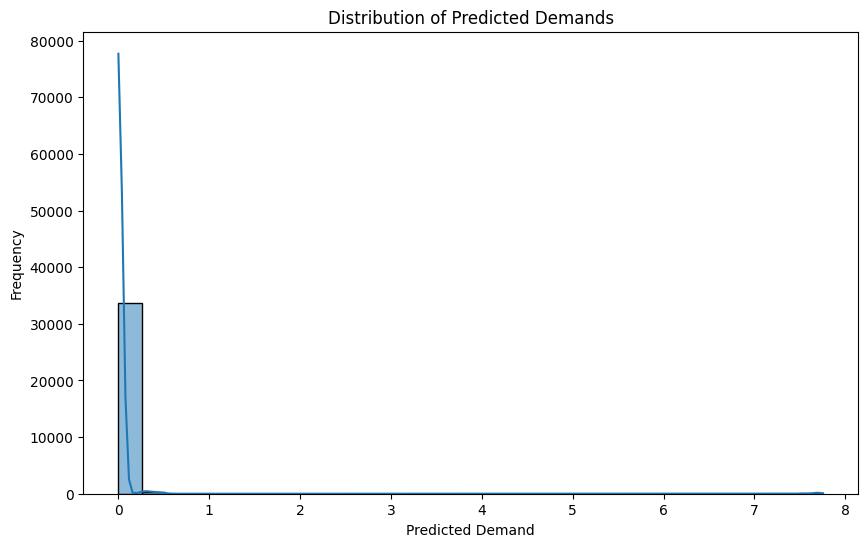

In [ ]:
# Plot the distribution of predicted demands
plt.figure(figsize=(10, 6))
sns.histplot(submission_df['demand'], bins=30, kde=True)
plt.title('Distribution of Predicted Demands')
plt.xlabel('Predicted Demand')
plt.ylabel('Frequency')
plt.show()

In [ ]:
actual_test_df = pd.read_csv('/content/drive/My Drive/hse-dab-lt-naf-24/lt_test.csv')

comparison_df = actual_test_df[['id', 'demand']].merge(submission_df[['id', 'demand']], on='id', suffixes=('_actual', '_predicted'))

# Plot actual vs. predicted demands
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['demand_actual'], comparison_df['demand_predicted'], alpha=0.5)
plt.plot([0, max(comparison_df['demand_actual'])], [0, max(comparison_df['demand_actual'])], 'r--')
plt.title('Actual vs Predicted Demands')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.show()

KeyError: "['demand'] not in index"

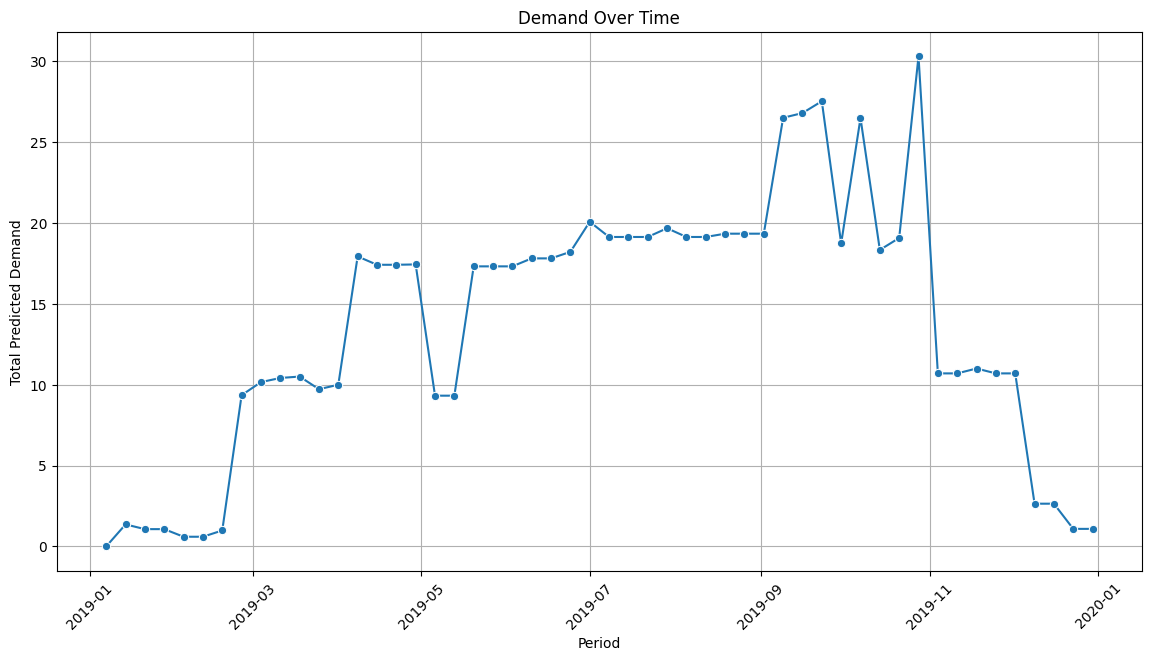

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'period_dt' is in datetime format
submission_df['period_dt'] = pd.to_datetime(submission_df['period_dt'])

# Group by 'period_dt' and sum the demands
demand_over_time = submission_df.groupby('period_dt')['demand'].sum().reset_index()

# Plot demand over time
plt.figure(figsize=(14, 7))
sns.lineplot(x='period_dt', y='demand', data=demand_over_time, marker='o')
plt.title('Demand Over Time')
plt.xlabel('Period')
plt.ylabel('Total Predicted Demand')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
